# Forked Neural Network

In [1]:
## Standard python libraries
import numpy as np
import time
import sys
import matplotlib.pylab as plt
import functools
%matplotlib inline

## Magnolia data iteration
sys.path.append('../../')
from src.features.mixer import FeatureMixer
from src.features.wav_iterator import batcher
from supervised_iterator_experiment import SupervisedIterator, SupervisedMixer

In [2]:
import tensorflow as tf
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf.Session(config=config)
print(tf.__version__)

1.1.0-rc2


## Set up the data

In [3]:
numsources = 2
batchsize = 256
datashape = (40, 257)
embedding_size = 600
restore_session=False
libridev='/local_data/teams/magnolia/libri-dev.h5'
libritrain='/local_data/teams/magnolia/librispeech/processed_train-clean-100.h5'

## Create a supervised mixer and batcher



In [4]:
if numsources == 3:
    mixer = SupervisedMixer([libritrain,libritrain,libritrain], shape=datashape, 
                         mix_method='add', diffseed=True, return_key=True)
else:
    mixer = SupervisedMixer([libritrain,libritrain], shape=datashape, 
                            mix_method='add', diffseed=True, return_key=True)


# Check the time
tbeg = time.clock()
X, Y, I = mixer.get_batch(batchsize)
tend = time.clock()
print('Supervised feature mixer with 3 libridev sources timed at ', (tend-tbeg), 'sec')

Supervised feature mixer with 3 libridev sources timed at  1.336228000000001 sec


## NEURAL NETWORK

The lost function takes in as input the variable `Vlast` for last layer ($V_{last}$, where a vector in $V_{last}$ is $v_{l}$). (That's the first couplet lines, where one just makes a tensorflow variable `Vlasttf`.)

The actual cost function is the *word2vec* objective function, where samples are positively and negatively sampled and then mixed. Let $A$ be a matrix of "attractors", so to speak. (We'll not use that terminology later on.) Then a positively sampled vector $a_p$ and a few negatively sampled ones $a_{n_1}$ and $a_{n_2}$ are all columns in $A$. The loss over a batch $B$ is denoted `tfbatchlo`, and is specified as:

$$ \mathcal{L}(v_{last}) = \log \sigma ( v_l^T a_p) + \sum_j \log \sigma( -1 \cdot v_l^T a_{n_j} )$$

In [8]:
def scope(function):
    attribute = '_cache_' + function.__name__
    name = function.__name__

    @property
    @functools.wraps(function)
    def decorator(self):
        if not hasattr(self,attribute):
            with tf.device("/gpu:0"):
                with tf.variable_scope(name):
                    setattr(self,attribute,function(self))
        return getattr(self,attribute)
    
    return decorator

class L41Convolve:
    def __init__(self, X, Y, F, I, layer_size, embedding_size, num_labels):
        
#         self.Vclass = tf.Variable(tf.random_normal( [embedding_size, num_labels, F], stddev=0.08 ), 
#                                   dtype=tf.float32,
#                                   name = 'Vclass')
        self.Vclass = tf.Variable(tf.random_normal( [embedding_size, num_labels, 1], stddev=0.05), 
                                  dtype=tf.float32, name='Vclass')
        
        self.X = X
        self.Y = Y
        
        self.F = F
        self.I = I
        
        self.layer_size = layer_size
        self.embedding_size = embedding_size
                
        self.network
        self.cost
        self.optimizer
        
    
    def weight_variable(self,shape):
        initial = tf.truncated_normal(shape, stddev=tf.sqrt(2.0/shape[0]))
        return tf.Variable(initial)
    
    def conv1d(self,x, W):
        return tf.nn.conv1d(x, W, stride=1, padding='SAME')
    
    def conv1d_layer(self,in_layer,shape):
        weights = self.weight_variable(shape)
        biases = self.weight_variable([shape[-1]])
        
        return self.conv1d(in_layer,weights) + biases
    
    def BLSTM(self, X, size, scope):
        forward_input = X
        backward_input = tf.reverse(X, [1])
        
        with tf.variable_scope('forward_' + scope):
            forward_lstm = tf.contrib.rnn.BasicLSTMCell(size//2)
            forward_out, f_state = tf.nn.dynamic_rnn(forward_lstm, forward_input, dtype=tf.float32)
        
        with tf.variable_scope('backward_' + scope):
            backward_lstm = tf.contrib.rnn.BasicLSTMCell(size//2)
            backward_out, b_state = tf.nn.dynamic_rnn(backward_lstm, backward_input, dtype=tf.float32)
        
        return tf.concat([forward_out[:,:,:], backward_out[:,::-1,:]], 2)
    
    @scope
    def network(self):
        shape = tf.shape(self.X)
        
        BLSTM_1 = self.BLSTM(self.X, self.layer_size, 'one')
        BLSTM_2 = self.BLSTM(BLSTM_1, self.layer_size, 'two')
        
        feedforward = self.conv1d_layer(BLSTM_2,[1,self.layer_size,self.embedding_size*self.F])
        
        embedding = tf.reshape(feedforward,[shape[0],shape[1],self.F,self.embedding_size]) 
        embedding = tf.nn.l2_normalize(embedding,3)
        
        return embedding
    
    @scope
    def cost(self):        
        
        Xshape=tf.shape(self.X)
        Yshape=tf.shape(self.Y)
        
        # things that are necessary for the cost function
        Vin = self.network
        I = tf.expand_dims( self.I, axis=2 )
        Y = self.Y
        Vclass = self.Vclass
        
        # l2 normalization
        Vclass = tf.nn.l2_normalize(Vclass, 0)
        
        # gather the appropriate vectors
        Vout = tf.gather_nd( tf.transpose(Vclass, perm=[1,2,0]), I )
        
        # Broadcasted Vi and Vo
        Vinbroad = tf.reshape( Vin, [Yshape[0], 1, Yshape[2], Yshape[3], self.embedding_size])
        Voutbroad= tf.reshape( Vout, [Yshape[0], Yshape[1], 1, 1, self.embedding_size] )
                
        # Correlate all the vectors:
        lossfxn = - tf.log( tf.nn.sigmoid( Y * tf.reduce_sum(Vinbroad * Voutbroad, 4) ) )
        
        # Sum correlations over positive and negative correlations
        lossfxn = tf.reduce_sum( lossfxn, 1 )
        
        # Average over all the batches
        lossfxn = tf.reduce_mean( lossfxn, 0)
        
        # To do: put weight by pre-emphasis or gradient confidence
        lossfxn = tf.reduce_mean( lossfxn )
        
        return lossfxn

    @scope
    def optimizer(self):
        opt = tf.train.AdamOptimizer()
        cost = self.cost
        return opt.minimize(cost)

In [9]:
tf.reset_default_graph()

F = 257
layer_size=600
embedding_size=40
X = tf.placeholder("float", [None,None,F])
Y = tf.placeholder("float", [None, None,None,F])
I = tf.placeholder(dtype=tf.int32)

num_labels=251

model = L41Convolve(X, Y, F, I, layer_size, embedding_size, num_labels)

sess = tf.Session()
sess.run(tf.global_variables_initializer())
saver = tf.train.Saver()

iterations = []
costs = []

if restore_session:
    saver.restore(sess, '/data/fs4/home/kni/magnolia/models/l41-model-2spkr-1embed.h5')

print("Initialized")

Initialized


In [ ]:
for iteration in range(1000000):

    # Preprocessing
    Xdata, Ydata, Idata = mixer.get_batch(batchsize, out_TF=None)    
    Xin = np.sqrt( abs(Xdata) )
    Xin = (Xin - Xin.min()) / (Xin.max() - Xin.min())

    optloss, cost = sess.run([model.optimizer, model.cost], feed_dict={X: Xin, Y:Ydata, I:Idata})
    costs += [cost]
    sys.stdout.write('\rIteration '+str(iteration)+', Cost function = '+str(cost))
    
    if not ((iteration+1) % 1000):
        save_path = saver.save(sess, "/data/fs4/home/kni/magnolia/models/l41-model-2spkr-expt-pos.h5")

Iteration 15, Cost function = 1.11473

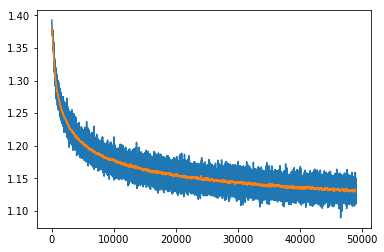

In [33]:
def meanfilter(costs):
    return np.convolve(np.array(costs), 1/100*np.ones(100), mode='valid')
smoothcosts = meanfilter(costs)
plt.plot(np.array(costs))
plt.plot(np.array(smoothcosts))

Supervised feature mixer with 3 libridev sources timed at  0.021605000001727603 sec


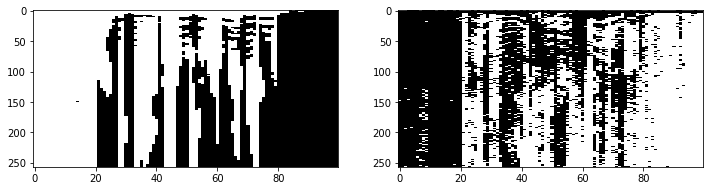

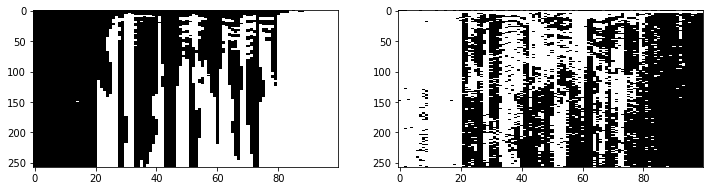

In [34]:
from src.utils.clustering_utils import get_cluster_masks
from src.features.hdf5_iterator import Hdf5Iterator
def sigmoid(x):
    return 1/(1+np.exp(-x))

if False:
    if numsources == 3:
        longmixer = SupervisedMixer([libritrain,libritrain,libritrain], shape=(200,257), 
                                    mix_method='add', diffseed=True, return_key=True)
    elif numsources == 2:
        longmixer = SupervisedMixer([libritrain,libritrain], shape=(100,257), 
                                    mix_method='add', diffseed=True, return_key=True)


# Check the time
tbeg = time.clock()
Xtest, Ytest, Itest = longmixer.get_batch(2, out_TF=None)
Xin = np.sqrt( abs(Xtest) )
Xin = (Xin - Xin.min()) / (Xin.max() - Xin.min())

tend = time.clock()
print('Supervised feature mixer with 3 libridev sources timed at ', (tend-tbeg), 'sec')

Vin, Vcl = sess.run([model.network, model.Vclass], feed_dict={X: abs(Xin), Y:Ytest, I:Idata})
masks = get_cluster_masks(Vin, 2)

plt.figure(figsize=(12,12)); 
plt.subplot(121); plt.imshow( masks[:,:,0].T, aspect=.2, cmap='bone' )
plt.subplot(122); plt.imshow( Ytest[0,0].T, aspect=.2, cmap='bone' )

plt.figure(figsize=(12,12)); 
plt.subplot(121); plt.imshow( masks[:,:,1].T, aspect=.2, cmap='bone' )
plt.subplot(122); plt.imshow( Ytest[0,1].T, aspect=.2, cmap='bone' )

if numsources == 3:
    plt.figure(figsize=(12,12)); 
    plt.subplot(121); plt.imshow( masks[:,:,2].T, aspect=.2, cmap='bone' )
    plt.subplot(122); plt.imshow( Ytest[0,2].T, aspect=.2, cmap='bone' )

In [35]:
from src.features.spectral_features import reconstruct
from IPython.display import Audio
from IPython.display import display

masks = get_cluster_masks(abs(Vin), 2)
masks = masks.transpose(2,0,1)
Ytest = (Ytest + 1)/2

# Stupid hack, there's a better way to do this
mask = masks[0]
soundshape = reconstruct( (abs(Xtest[0]) * mask), np.angle(Xtest[0]), 10000, 0.0512, 0.0256 ).shape
Xsound = np.zeros( (numsources+1, soundshape[0]) )
Ysound = np.zeros( (numsources, soundshape[0]) )

Xsound[0] = reconstruct( abs(Xtest[0]), Xtest[0], 10000, 0.0512, 0.0256 )
for i, mask in enumerate(masks):
    Xsound[i+1] = reconstruct( abs(Xtest[0]) * mask, Xtest[0], 10000, 0.0512, 0.0256 )
    Ysound[i] = reconstruct( abs(Xtest[0]) * Ytest[0,i], Xtest[0], 10000, 0.0512, 0.0256 )
    
    
print("ORIGINAL")
display(Audio(Xsound[0], rate=10000))
print("IDEAL MASK 1")
display(Audio(Ysound[0], rate=10000))
print("PREDICTED MASK 1")
display(Audio(Xsound[1], rate=10000))
print("IDEAL MASK 2")
display(Audio(Ysound[1], rate=10000))
print("PREDICTED MASK 2")
display(Audio(Xsound[2], rate=10000))

ORIGINAL


IDEAL MASK 1


PREDICTED MASK 1


IDEAL MASK 2


PREDICTED MASK 2


In [ ]:
# Vcl_30k = sess.run( tf.trainable_variables()[1] )
# Vcl_31k = sess.run( tf.trainable_variables()[1] )
tf.trainable_variables()